# PHYS20762 - Project - Numerical Integration Of Differential Equations For The Damped Harmonic Oscillator 

Jatin Sharma<br>
University of Manchester  
January 2021

We first initialise our Python interpreter


In [1]:
# Initialisation
import string
import cmath
from math import *
import math
import numpy as np
from numpy.linalg import inv
from numpy import zeros, linspace
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

In [2]:
# Constants 
k = 2.98 # Spring constant - N/m
m = 3.67 # Mass - Kg
b_cr = np.sqrt(4 * k * m) # Critical damping term - kg/s
w0 = np.sqrt(k / m) # Natural frequency - rad/s

In [3]:
# Functions

def analytic_solution(x0, v0, time):
    """
    Calculates the analytical solution for a overdamped, underdamped and critically damped harmonic oscillator system. 

    Parameters
    ----------
    x0 : float
    initial displacement 
    v0 : float
    initial velocity
    time : numpy array
    range of times

    Returns
    -------
    x : numpy array
    array of displacements at different times 
    v : numpy array
    array of velocitys at different times 
    E : numpy array
    array of energys at different times 
    
    """
    if b != b_cr:
        # Constants
        A = (b / (2 * 1j * cmath.sqrt(4 * k * m - b**2)) + 1 / 2) * x0 + v0 * m / (cmath.sqrt(4 * k * m -b**2) * 1j) 
        B = x0-A
        # Find x, v and E for the overdamped and underdamped systems
        x = np.exp(-b * time / (2 * m)) * (A * np.exp(1j * cmath.sqrt(4 * k * m - b**2) * time / (2 * m))
                                  + B * np.exp(-1j * cmath.sqrt(4 * k * m-b**2) * time / (2 * m)))
        v = (np.exp(-b * time/(2 * m)) * A * np.exp(1j * cmath.sqrt(4 * k * m-b**2) * time / (2 * m)) \
        * ((-b / (2 * m)) + 1j * cmath.sqrt(4 * k * m - b**2) / (2 * m))) + (np.exp(-b * time / (2 * m)) * B * np.exp(-1j *\
        cmath.sqrt(4 * k * m-b**2) * time / (2 * m)) * ((-b / (2 * m)) - 1j * cmath.sqrt(4 * k * m - b**2) / (2 * m)))
        E = ((k * x**2) / 2) + ((m * v**2) / 2)
    else:
        # Constants
        gamma = b / m
        A = x0
        B = v0 + (b / (2 * m)) * x0
        # Find x, v and E for the critically damped system
        x = np.exp(-b * time / (2 * m)) * (A + (B * time))
        v = (np.exp(-b * time / (2 * m))) * (-(b / (2 * m)) * (A + B * time) + B)
        E = ((k * x**2) / 2) + ((m * v**2) / 2)
    return x, v, E.real

def euler_method(x0, v0, nsteps, hstep):
    """
    Implements the Euler method for a mass spring system.

    Parameters
    ----------
    x0 : float
    initial displacement 
    v0 : float
    initial velocity
    nsteps : int
    total number of steps
    hstep : float
    size of each individual step
    
    Returns
    -------
    x : numpy array
    array of displacements at different steps
    v : numpy array
    array of velocitys at different steps
    error : numpy array 
    difference between the energy found using the euler method and the expected energy.

    """
    # Create empty arrays ready for the values of x, v, E and error
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    E = np.zeros(nsteps)
    error = np.zeros(nsteps)
    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    E[0] =((k * x0**2) / 2) + (1 / 2) * m * v0**2 
    for i in range(nsteps-1):
        # Calculate the acceleration at step i (in m/s)
        a = -(k / m) * x[i] - (b / m) * v[i]
        # For each configuration at step i, calculate x (in m), v (in m/s), E (in J) and error (in J) for the later step i+1
        x[i+1] = x[i] + v[i] * hstep
        v[i+1] = v[i] + a * hstep
        E[i+1] = ((k * x[i+1]**2) / 2) + ((m * v[i+1]**2) / 2)
        error[i+1] = E[i+1] - analytic_solution(-1, 0, hstep * nsteps)[2]
    return (x, v, error) 

def improved_euler_method(x0, v0, nsteps, hstep):
    """
    Implements the improved Euler method for a mass spring system.

    Parameters
    ----------
    x0 : float
    initial displacement
    v0 : float
    initial velocity 
    nsteps : int
    total number of steps
    hstep : float
    size of each individual step

    Returns
    -------
    x : numpy array
    array of displacements at different steps
    v : numpy array
    array of velocitys at different steps
    error : numpy array 
    difference between the energy found using the improved euler method and the expected energy.
    
    """
    # Create empty arrays ready for the values of x, v, E and error
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    E = np.zeros(nsteps)
    error = np.zeros(nsteps)
    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    E[0] =((k * x0**2) / 2) + (1 / 2) * m * v0**2 
    for i in range(nsteps-1):
        # Calculate the acceleration at step i (in m/s)
        a = -(k / m) * x[i] - (b / m) * v[i]
        # For each configuration at step i, calculate x (in m), v (in m/s), E (in J) and error (in J) for the later step i+1
        x[i+1] = x[i] + v[i] * hstep + ((hstep**2) / 2) * a
        v[i+1] = v[i] + a * hstep
        E[i+1] = ((k * x[i+1]**2) / 2) + ((m * v[i+1]**2) / 2)
        error[i+1] = E[i+1] - analytic_solution(-1, 0, hstep * nsteps)[2]
    return (x, v, error) 
    
def verlet_method(x0, v0, nsteps, hstep):
    """
    Implements the Verlet method for a mass spring system.

    Parameters
    ----------
    x0 : float
    initial displacement
    v0 : float
    initial velocity 
    nsteps : int
    total number of steps
    hstep : float
    size of each individual step

    Returns
    -------
    x : numpy array 
    array of displacements at different steps
    v : numpy array
    array of velocitys at different steps
    error : numpy array 
    difference between the energy found using the Verlet method and the expected energy.
    
    """
    # Create empty arrays ready for the values of x, v, E and error
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    E = np.zeros(nsteps)
    error = np.zeros(nsteps)
    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    E[0] =((k * x0**2) / 2) + (1 / 2) * m * v0**2 
    # Use the euler method to find x[1]
    x[1] = x[0] + v[0] * hstep
    for i in range(1, nsteps-1):
        # Constants 
        D = 2 * m + b * hstep
        A = 2 * (((2 * m) - k * hstep**2) / D)
        B = ((b * hstep) - 2 * m) / D
        # For each configuration at step i, calculate x (in m), v (in m/s), E (in J) and error (in J) for the later step i+1
        x[i+1] = A * x[i] + B * x[i-1]
        v[i] = (x[i+1] - x[i-1]) / (2 * hstep)
        E[i] = ((k * x[i]**2) / 2) + ((m * v[i]**2) / 2)
        error[i] = E[i] - analytic_solution(-1, 0, hstep * nsteps)[2]
    return x, v, error


def euler_cromer_method(x0, v0, nsteps, hstep):
    """
    Implements the Euler-Cromer method for a mass spring system.

    Parameters
    ----------
    x0 : float
    initial displacement
    v0 : float
    initial velocity 
    nsteps : int
    total number of steps
    hstep : float
    size of each individual step

    Returns
    -------
    x : numpy array  
    array of displacements at different steps
    v : numpy array
    array of velocitys at different steps
    error : numpy array 
    difference between the energy found using the euler-cromer method and the expected energy.
    
    """
    # Create empty arrays ready for the values of x,v and E
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    E = np.zeros(nsteps)
    error = np.zeros(nsteps)
    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    E[0] =((k * x0**2) / 2) + (1 / 2) * m * v0**2
    for i in range(nsteps-1):
        # Calculate the acceleration at step i (in m/s)
        a = -(k / m) * x[i] - (b / m) * v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        v[i+1] = v[i] + a * hstep
        x[i+1] = x[i] + v[i+1] * hstep
        E[i+1] = ((k * x[i+1]**2) / 2) + ((m * v[i+1]**2) / 2)
        error[i+1] = E[i+1] - analytic_solution(-1, 0, hstep * nsteps)[2] 
    return (x, v, error) 

def error_threshold_calculator(prespecified_error, method):
    """
    For a range of hstep values the error of a numerical method is found, where the error is less than 
    or equal to the prespecified error.

    Parameters
    ----------
    prespecified_error : float
    method : N/A
    The method you want to calculate the error threshold for

    Returns
    -------
    None
    
    """
    hstep = np.arange(0.01,1,0.2)
    # loop through different hstep values and find when the error reduces below the prespecefied error.
    for h in hstep:
        nsteps = int(T / h)
        _, _, error = method(0, -1, nsteps, h)
        for err in error[1:]:
            if err<=prespecified_error:
                print('hstep : nsteps : error = {0:.4g} : {1:.7g} : {2:.10g}'.format(h, nsteps, err))
                break
    return None

def euler_cromer_sudden_force(x0, v0, nsteps, hstep, F, iteration):
    """
    Implements the Euler-Cromer method for a mass spring system and implements a sudden force at a specified iteration step.

    Parameters
    ----------
    x0 : float
    initial displacement
    v0 : float
    initial velocity 
    nsteps : int
    total number of steps
    hstep : float
    size of each individual step
    F : function
    The formula of the driving force
    iteration: int
    The value of counts in which the sudden force is applied

    Returns
    -------
    x : array  
    array of displacements at different steps
    v : array
    array of velocitys at different steps
    t : array
    array of times at different steps
    
    """
    nstep = int(round(T / hstep))
    t = linspace(0, nstep * hstep, nstep + 1)
    x = zeros(nstep + 1)
    v = zeros(nstep + 1)
    # Initial condition
    x[0] = x0
    v[0] = v0
    # Step equations forward in time
    count = 0
    for i in range(nstep):
        # Calculate the acceleration at step i (in m/s)
        a = -(k / m) * x[i] - (b / m) * v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        v[i+1] = v[i] + a * hstep
        x[i+1] = x[i] + hstep*v[i+1]
        count += 1
        # Now implement the sudden force
        if count == iteration:
            v[i+1] = v[i] + hstep*(1 / m)*(F(t[i]) - (b / m) * (v[i]) - (k / m) * (x[i]))
            x[i+1] = x[i] + hstep*v[i+1]
    return x, v, t

def euler_cromer_sinusoidal_force(F, x0, v0, hstep, b):
    """
    Implements the Euler-Cromer method for a mass spring system and implements a force for all of time.

    Parameters
    ----------
    x0 : float
    initial displacement
    v0 : float
    initial velocity 
    hsteps : float
    size of each individual step
    F : function
    The formula of the driving force
    b: float
    The value of damping

    Returns
    -------
    x : array  
    array of displacements at different steps
    v : array
    array of velocitys at different steps
    t : array
    array of times at different steps
    
    """
    nstep = int(round(T / hstep))
    t = linspace(0.1, nstep * hstep, nstep + 1)
    x = zeros(nstep + 1)
    v = zeros(nstep + 1)
    # Initial condition
    x[0] = x0
    v[0] = v0
    # Step equations forward in time
    for i in range(nstep):
        v[i+1] = v[i] + hstep*(1 / m)*(F(t[i]) - (b / m) * (v[i]) - (k / m) * (x[i]))
        x[i+1] = x[i] + hstep*v[i+1]
    return x, v, t

def sin_func(times, amp, freq):
    """
    Calculates the value of a sinusoidal function at a specified time, amplitude and frequency.

    Parameters
    ----------
    times : float
    amp : float 
    freq : float

    Returns
    -------
    amp * np.sin(freq * times) : float  
    
    """
    return amp * np.sin(freq * times)

def F(t):
    """
    A sinusoidal force function used whithin the rung_kutta_4 function.

    Returns
    -------
    F : float  
    
    """
    F = np.array([0,0.0])
    # Apply a sinusoidal force for a certain time
    if t <= 40:
        F[0] = F0 * np.sin(omega*t)
    else:
        F[0] = 0.0
    return F

def runge_kutta_4(x0, v0, time):
    """
    Implements the Runge-Kutta 4th order method for a mass spring system.

    Parameters
    ----------
    x0 : float
    initial displacement
    v0 : float
    initial velocity 
    time : array
    array of times

    Returns
    -------
    x : array  
    array of displacements at different steps
    E : array
    array of energies at different steps
    error : numpy array 
    difference between the energy found using the Runge-Kutta method and the expected energy.  
    
    """
    # initial state
    y = np.array([v0, x0])   # [velocity, displacement]
    # Create arrays for constant values
    A = np.array([[m,0],[0,1]])
    B = np.array([[b,k],[-1,0]])
    A_inv = inv(A)
    # Create empty arrays that need filling
    x = []
    force = []
    E = []
    error = []
    # time-stepping solution
    for t in time:
        y = y + RK4_step(y, t, hstep) 
        x.append(y[1])
        force.append(F(t)[0])
        KE = 0.5 * m * y[0]**2
        PE = 0.5 * k * y[1]**2
        e = KE + PE
        E.append(e)
        error_value = e - analytic_solution(-1, 0, t)[2] 
        error.append(error_value)
    return(x, E, error)

def G(y,t): 
    """
    A function of initial conditions used in the RK4_step function.

    Returns
    -------
    A_inv.dot(F(t) - B.dot(y)) : float 
    
    """
    A = np.array([[m, 0], [0, 1]])
    B = np.array([[b, k], [-1, 0]])
    A_inv = inv(A)
    return A_inv.dot(F(t) - B.dot(y))

def RK4_step(y, t, dt):
    """
    One step in the Runge-Kutta 4th order method for a mass spring system.

    Parameters
    ----------
    y : array
    array of initial conditions
    t : float
    time values  
    dt : float
    small step in time

    Returns
    -------
    dt * G(y, t) : float
    dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6 : float
    
    """
    k1 = G(y, t)
    k2 = G(y + 0.5 * k1 * dt, t + 0.5 * dt)
    k3 = G(y + 0.5 * k2 * dt, t + 0.5 * dt)
    k4 = G(y + k3 * dt, t + dt)
    return dt * G(y,t)
    return dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6



## The Damped Oscillator 

The damped oscillator system is generally subject to an external force $F(t)$:
$$F(t) = ma(t) + bv(t) + kx(t),$$
where 
$x$ is the displacement of the oscillator, $v$ and $a$ are the velocity and acceleration of the system, $m$ is the mass, $k$ is the spring constant and $b$ is the damping constant.

In this report we will first assume $F(t) = 0$ and from this will calculate $x(t)$ using four different methods, Euler, improved Euler, Verlet and Euler-Cromer. Therefore, initially we are solving the equation:
$$0 = ma(t) + bv(t) + kx(t).$$
We will also intially assume $x (t=0) = x_0 = 0$m and $v (t=0) = v_0 = -1$m/s

In [4]:
# Define some constant values used in this section 
# Choose some physics parameters 
b = 0.08 #kg/s
x0 = 0 #m
v0 = -1 #m/s
# Choose how long we are integrating for (in s)
T = 221
# Choose the step size (in s)
hstep = 0.01
# Determine how many steps there are; we need to use int to ensure we have a whole number of them, otherwise the loops
#won't work
nsteps = int(T / hstep)

# Euler's Method

Assuming h is a small *time step*, the **Euler's Method** is 
$$x_{i+1} = x_{i} + h \cdot v_{i}$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$    
where  
$$a_{i} = -\frac{k}{m} x_{i} -{b} \cdot {m}\cdot v_{i}.$$ Here $i$ labels the number of steps taken (each of size $h$ in time). This allows us to model the system over some specified time from $t =0$ to $t=T$.  

Now implement Euler's method.

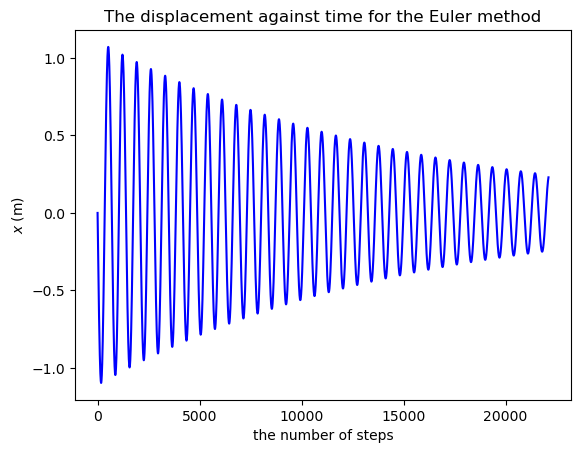

In [5]:
# Find the displacement and velocity using the Euler method
x_euler, v_euler, _ = euler_method(x0, v0, nsteps, hstep)
# Plot the positions and velocities on the same axes
plt.plot(x_euler,'b')
plt.xlabel("the number of steps")
plt.ylabel("$x$ (m)")
plt.title('The displacement against time for the Euler method')
plt.show()

# Improved Euler's Method

Assuming h is a small *time step*, the **Improved Euler's Method** is 
$$x_{i+1} = x_{i} + h \cdot v_{i} + \frac{h^2 \cdot a_{i}}{2}$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$    
where  
$$a_{i} = -\frac{k}{m} x_{i} -\frac{b}{m} v_{i}.$$ Here $i$ labels the number of steps taken (each of size $h$ in time). This allows us to model the system over some specified time from $t =0$ to $t=T$. 

Now implement the improved Euler method.

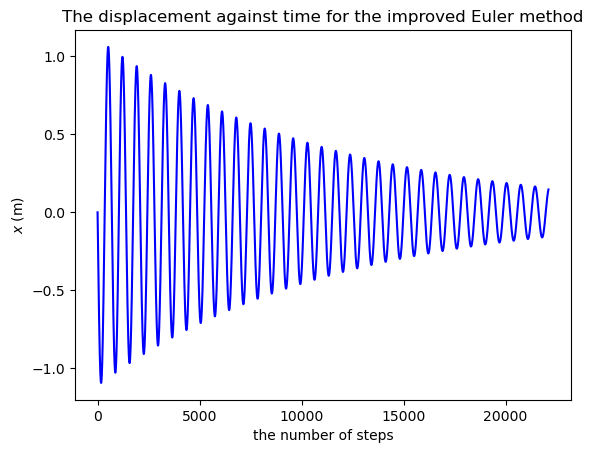

In [6]:
# Find the displacement and velocity using the improved Euler method
x_improved_euler, v_improved_euler, _ = improved_euler_method(x0, v0, nsteps, hstep)
# Plot the positions and velocities on the same axes
plt.plot(x_improved_euler,'b')
plt.xlabel("the number of steps")
plt.ylabel("$x$ (m)")
plt.title('The displacement against time for the improved Euler method')
plt.show()

# Verlet's Method

Assuming h is a small *time step*, the **Verlet Method** is 
$$x_{i+1} = A \cdot x_{i} + B \cdot x_{i-1}$$ 
where  
$$A = \frac{2m - k\cdot h^2}{D},$$ 
$$B = \frac{b\cdot h-2m}{D}$$
and $$D=2m+bh.$$Here $i$ labels the number of steps taken (each of size $h$ in time). This allows us to model the system over some specified time from $t =0$ to $t=T$. 

Verlet's method is not self starting like both Euler methods. To see this we let $i = 0$ in the above expression for $x_{i+1}$ to obtain
$$x_{1} = A \cdot x_{0} + B \cdot x_{-1}.$$ The term $x_{-1}$ has no physical meaning, so $x_{1}$ can not be determined using this method. Instead the Euler method is used to find $x_{1}$, which enables the Verlet method to start. 

Now implement Verlet's method

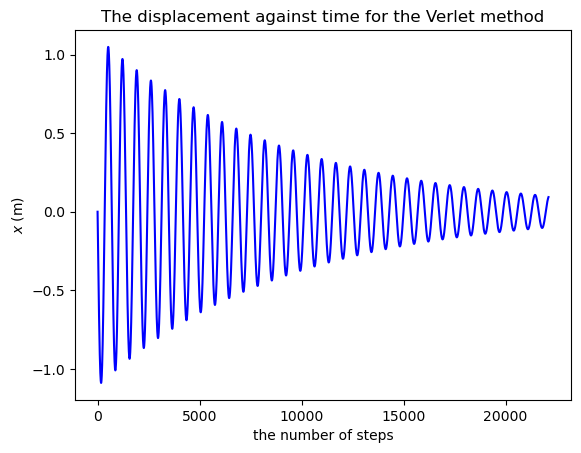

In [7]:
x_verlet, v_verlet, _ = verlet_method(0, -1, nsteps, hstep)
# Plot the positions
plt.plot(x_verlet,'b')
plt.xlabel("the number of steps")
plt.ylabel("$x$ (m)")
plt.title('The displacement against time for the Verlet method')
plt.show()

# Euler-Cromer Method

Assuming h is a small *time step*, the **Euler-Cromer Method** is 
$$x_{i+1} = x_{i} + h \cdot v_{i+1}$$ 
$$v_{i+1} = v_{i} - \frac{h\cdot k\cdot x_{i}}{m}$$
Here $i$ labels the number of steps taken (each of size $h$ in time). This allows us to model the system over some specified time from $t =0$ to $t=T$. 

Now implement the Euler-Cromer method

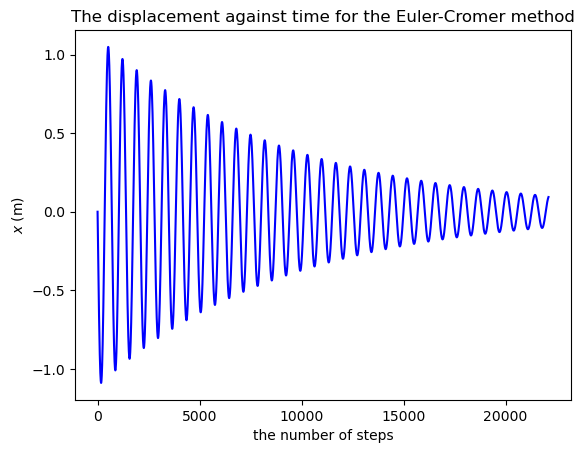

In [8]:
x_euler_cromer, v_euler_cromer, _ = euler_cromer_method(0, -1, nsteps, hstep)
# Plot the positions
plt.plot(x_euler_cromer,'b')
plt.xlabel("the number of steps")
plt.ylabel("$x$ (m)")
plt.title('The displacement against time for the Euler-Cromer method')
plt.show()

# The Analytical Solution

For the overdamped and underdamped system, the analytical solution for $x(t)$ is
$$x(t) = e^{-\frac{\gamma t}{2}}(Ae^{iwt}+Be^{-iwt}),$$
by taking the time derivative of $x(t)$ we obtain
$$v(t) = e^{-\frac{\gamma t}{2}}Ae^{iwt}(-\frac{\gamma}{2} + iw) + e^{-\frac{\gamma t}{2}}Be^{-iwt}(-\frac{\gamma}{2} - iw),$$
where $\gamma = \frac{b}{m}$ and $w^2 = \frac{k}{m} -\frac{b^2}{4m^2}.$  

The form of $x(t)$ and $v(t)$ are different for a critically damped system. They take the form of
$$x(t) = e^{\frac{\gamma t}{2}}(A + Bt),$$
and
$$v(t) = e^{\frac{\gamma t}{2}}(\frac{-\gamma}{2}(A+Bt)+B).$$


Now plot the numerical solutions found for $x(t)$ alongside the analytical solution against $t$.

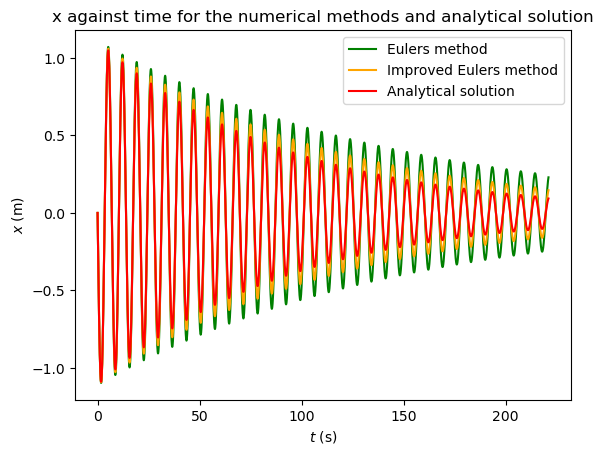

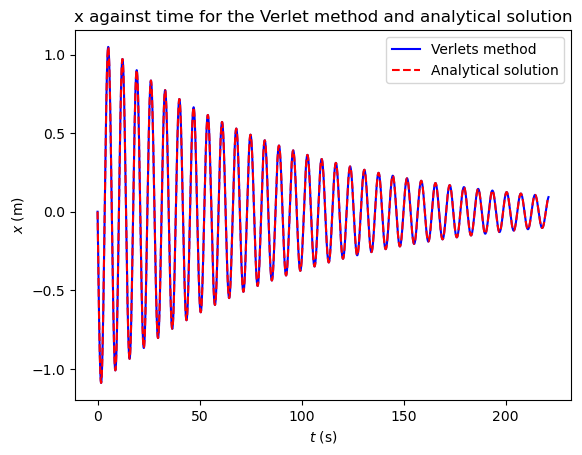

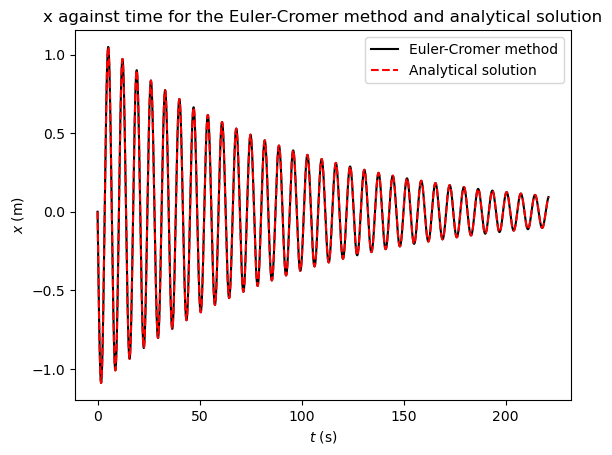

In [9]:
fig_1, ax_1 = plt.subplots(1)
#Plot a graph of x against time for the numerical methods
ax_1.plot(np.arange(0,T,hstep), x_euler, 'g', label='Eulers method')
ax_1.plot(np.arange(0,T,hstep), x_improved_euler, 'orange', label='Improved Eulers method')
#Plot the analytical solution
ax_1.plot(np.arange(0,T,hstep), analytic_solution(x0, v0, np.arange(0,T,hstep))[0].real, 'r', label='Analytical solution')
ax_1.set_xlabel('$t$ (s)')
ax_1.set_ylabel('$x$ (m)')
ax_1.set_title('x against time for the numerical methods and analytical solution')
leg = ax_1.legend()
#Plot a second figure for the verlet method and analytical solution
fig_2, ax_2 = plt.subplots(1)
ax_2.plot(np.arange(0,T,hstep), x_verlet, 'b', label='Verlets method')
#Plot the analytical solution
ax_2.plot(np.arange(0,T,hstep), analytic_solution(x0, v0, np.arange(0,T,hstep))[0].real, '--r', label='Analytical solution')
ax_2.set_xlabel('$t$ (s)')
ax_2.set_ylabel('$x$ (m)')
ax_2.set_title('x against time for the Verlet method and analytical solution')
leg = ax_2.legend()
#Plot a third figure for the Euler-Cromer method and analytical solution
fig_3, ax_3 = plt.subplots(1)
ax_3.plot(np.arange(0,T,hstep), x_euler_cromer, 'k', label='Euler-Cromer method')
#Plot the analytical solution
ax_3.plot(np.arange(0,T,hstep), analytic_solution(x0, v0, np.arange(0,T,hstep))[0].real, '--r', label='Analytical solution')
ax_3.set_xlabel('$t$ (s)')
ax_3.set_ylabel('$x$ (m)')
ax_3.set_title('x against time for the Euler-Cromer method and analytical solution')
leg = ax_3.legend()


It is clear from the above plots that the Euler-Cromer method and Verlet's method fit the analytical solution the best for a step size of 0.1.

# Finding The Accuracy Of Each Method 

Analytically the energy of this system is
$$E(t) = \frac{mv(t)^2}{2} + \frac{kx(t)^2}{2}.$$
Numerically the energy of the system at the $i+1$ step can be found using
$$E_{i+1} = \frac{kx_{i+1}^2}{2} + \frac{mv_{i+1}^2}{2}.$$
Finally the error is given by 
$$error = E_{i+1} - E(t).$$
We can also vary the step size and see how this effects the error for each method.

In [10]:
# Define constant used for this section 
# Choose a range of step sizes (in s)
h = (0.005, 0.01, 0.05, 0.1)

# Euler's Method

The energy at the $i+1$ step can be found using
$$E_{i+1} = \frac{kx_{i+1}^2}{2} + \frac{mv_{i+1}^2}{2}.$$
By substituiting $x_{i+1}$ and $v_{i+1}$ in to the expression found for $E_{i+1}$ gives the energy of the system predicted by the Euler method
$$E_{i+1} = E_i(1 + \frac{kh^2}{m}).$$
According to this formula $E$ increases over time, however we expect the energy to be conserved with time.
The error at each step $i + 1$ is then
$$ \varepsilon_{i+1} = E_{i+1} - \frac{mv_0^2}{2} - \frac{kx_0^2}{2}.$$

Now lets calculate the error for the Euler method

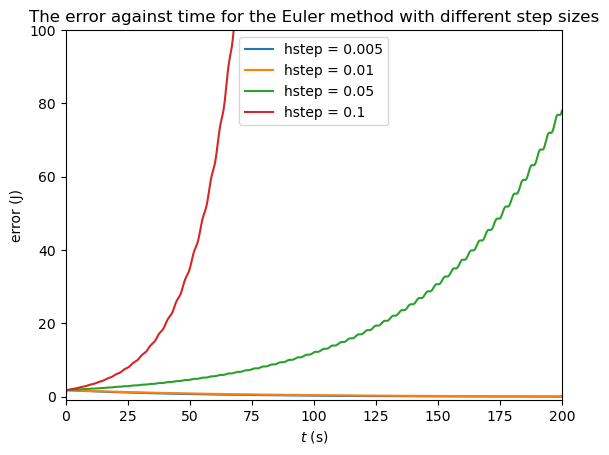

In [11]:
# Finding the solution for a range of step sizes 
for hstep in h:
    # Determine how many steps there are (values of i); we need to use int to ensure we have a whole number
    # of them, otherwise the loops won't work
    nsteps = int(T / hstep)
    # Find the energy of the system according to the Euler method and the difference between this Energy and the 
    # analytical energy (error)
    _, _, error = euler_method(x0, v0, nsteps, hstep)
    # plot the outcome by displaying the error only 
    plt.plot(np.arange(0,T,hstep), error, label='hstep = {}'.format(hstep))
# labeling plot 
plt.title('The error against time for the Euler method with different step sizes')
plt.xlabel("$t$ (s)")
plt.ylabel("error (J)")
plt.legend()
# setting the range displayed
plt.xlim(0, 200)
plt.ylim(-0.8, 100)
plt.show()

The smaller the step size the smaller the error is. For step sizes of 0.1 and 0.05 the error clearly increases with time. 

# Improved Euler's Method 

First lets consider the improved Euler method for $b=0$. This is given by
$$x_{i+1} = x_{i} + h \cdot v_{i} + \frac{h^2 \cdot a_{i}}{2}$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$    
where  
$$a_{i} = -\frac{k}{m} x_{i}.$$ 
Now the energy at the $i+1$ step can be found using
$$E_{i+1} = \frac{kx_{i+1}^2}{2} + \frac{mv_{i+1}^2}{2}.$$
By substituiting $x_{i+1}$ and $v_{i+1}$ in to the expression found for $E_{i+1}$ gives the energy of the system predicted by the Euler method. This is 
$$E_{i+1} = E_i + hkv_ix_i-h^2v_ix_i+\frac{h^2kv^2_i}{2}-\frac{h^3kx^2_i}{2m}+\frac{h^4x^2_i}{2m}-\frac{h^4kv_ix_i}{2m}+\frac{h^6kx^2_i}{8m^2}.$$
$E$ increases over time according to this formula.
The error at each step $i + 1$ is then
$$ \varepsilon_{i+1} = E_{i+1} - \frac{mv_0^2}{2} - \frac{kx_0^2}{2}.$$
We will include $b$ in the discussion below.

Now lets calculate the error for the improved Euler method

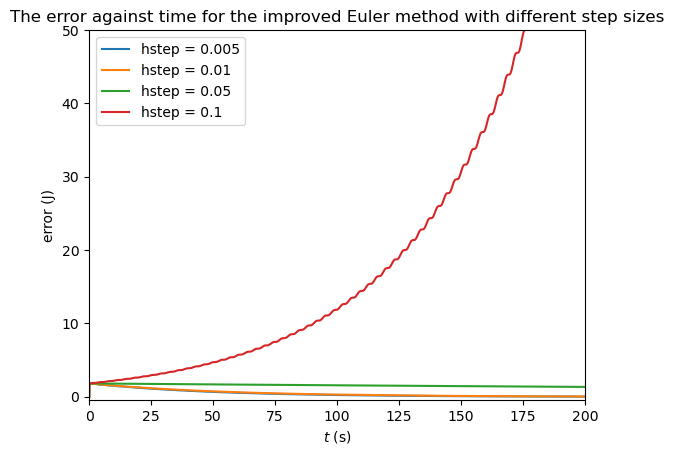

In [12]:
# Finding the solution for a range of step sizes 
for hstep in h:
    # Determine how many steps there are (values of i); we need to use int to ensure we have a whole number
    # of them, otherwise the loops won't work
    nsteps = int(T / hstep)
    # Find the energy of the system according to the improved Euler method and the difference between this Energy and the 
    # analytical energy (error)
    _, _, error = improved_euler_method(x0, v0, nsteps, hstep)
    # plot the outcome by displaying the error only 
    plt.plot(np.arange(0,T,hstep), error, label='hstep = {}'.format(hstep))
# labeling plot 
plt.title('The error against time for the improved Euler method with different step sizes')
plt.xlabel("$t$ (s)")
plt.ylabel("error (J)")
plt.legend()
# setting the range displayed
plt.xlim(0, 200)
plt.ylim(-0.4, 50)
plt.show()

The result for varying step size is similiar to that of the Euler method. However, a much smaller error is achieved for a step size of 0.05 and the error for a step size of 0.1 does not increase as quickly as before. This method is still not good as a small step size is required for a small error.

# Verlet's Method

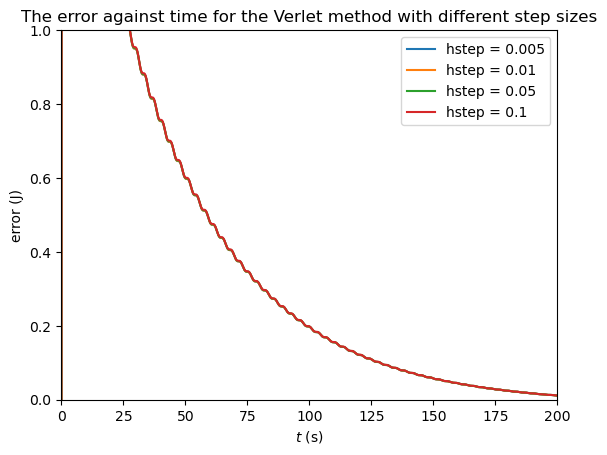

In [13]:
# Finding the solution for a range of step sizes 
for hstep in h:
    # Determine how many steps there are (values of i); we need to use int to ensure we have a whole number
    # of them, otherwise the loops won't work
    nsteps = int(T / hstep)
    # Find the energy of the system according to the Verlet method and the difference between this Energy and the 
    # analytical energy (error)
    _, _, error = verlet_method(0, -1, nsteps, hstep)
    # plot the outcome by displaying the error only 
    plt.plot(np.arange(0,T,hstep), error, label='hstep = {}'.format(hstep))
# labeling plot 
plt.title('The error against time for the Verlet method with different step sizes')
plt.xlabel("$t$ (s)")
plt.ylabel("error (J)")
plt.legend()
# setting the range displayed
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.show()

The error value is much smaller than that of the Euler-Cromer and Euler methods. The error doesn't change drastically with step size like the previous two methods. This means the Verlet method is much more reliable for this system than the previous two methods discussed.

# Euler-Cromer Method 

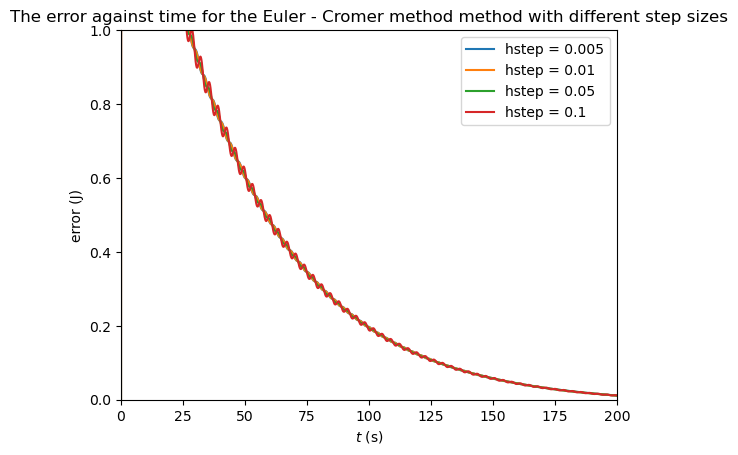

In [14]:
# Finding the solution for a range of step sizes 
for hstep in h:
    # Determine how many steps there are (values of i); we need to use int to ensure we have a whole number
    # of them, otherwise the loops won't work
    nsteps = int(T / hstep)
    # Find the energy of the system according to the Euler-cromer method and the difference between this Energy and the 
    # analytical energy (error)
    _, _, error = euler_cromer_method(x0, v0, nsteps, hstep)
    # plot the outcome by displaying the error only 
    plt.plot(np.arange(0,T,hstep), error, label='hstep = {}'.format(hstep))
# labeling plot 
plt.title('The error against time for the Euler - Cromer method method with different step sizes')
plt.xlabel("$t$ (s)")
plt.ylabel("error (J)")
plt.legend()
# setting the range displayed
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.show()

Clearly the Verlet and Euler-Cromer methods work the best as there errors are much smaller than that for the Euler and improved Euler methods. However, it is not obvious which method out of the Verlet and Euler-Cromer are best. To demonstrate which one is better we can print the error results at specific step sizes and nstep values and compare which ones are smaller.

In [15]:
specified_error = 0.009
print('Results of the Euler-Cromer method:')
print()
error_threshold_calculator(specified_error, euler_cromer_method)
print()
print('Results of the Verlet method:')
error_threshold_calculator(specified_error, verlet_method)

Results of the Euler-Cromer method:

hstep : nsteps : error = 0.01 : 22100 : 0.008997010658
hstep : nsteps : error = 0.21 : 1052 : 0.008886404657
hstep : nsteps : error = 0.41 : 539 : 0.008967467294
hstep : nsteps : error = 0.61 : 362 : 0.008371808027
hstep : nsteps : error = 0.81 : 272 : 0.007685903275

Results of the Verlet method:
hstep : nsteps : error = 0.01 : 22100 : 0.008992558025
hstep : nsteps : error = 0.21 : 1052 : 0.008977908085
hstep : nsteps : error = 0.41 : 539 : 0.008783507922
hstep : nsteps : error = 0.61 : 362 : 0.008814664952
hstep : nsteps : error = 0.81 : 272 : 0.008521573451


We can see that the Euler-Cromer method gives a slighly lower error in the cases considered above, therefore being the more accurate method. From the investigation presented we can say the Euler-Cromer method is the best method.

# Varying The Damping Term, $b$

Now we will plot solutions for various values of $b$. Three cases will be considered, $b = \frac{b_{cr}}{2}$, $b=b_{cr}$ and $b=2b_{cr}$, for $b_{cr}=\sqrt{4km}$, where $b_{cr}$ is the critical damping term. 

In [16]:
# Define constant used in this section
# Choose a range of damping values
b_values = (b_cr / 2, b_cr, 2 * b_cr)

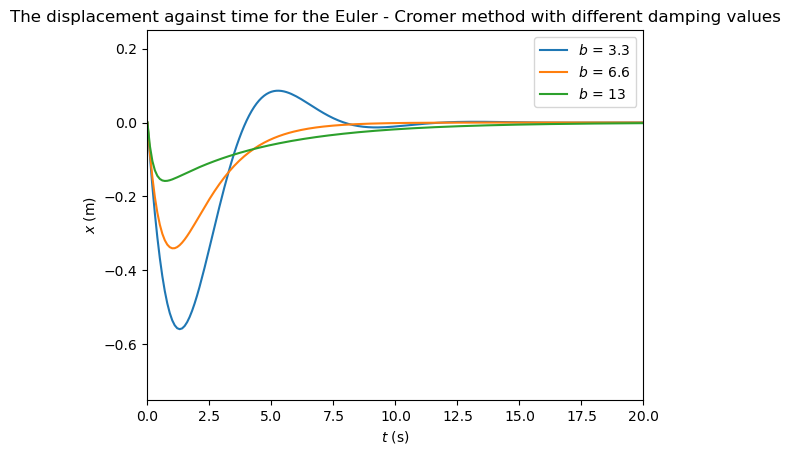

In [17]:
# Finding the solution for a range of damping values
for b in b_values:
    x, _, _ = euler_cromer_method(x0, v0, nsteps, hstep)
    # plot the outcome 
    plt.plot(np.arange(0,T,hstep), x, label='$b$ = {0:.2g}'.format(b))
# labeling plot 
plt.title('The displacement against time for the Euler - Cromer method with different damping values')
plt.xlabel("$t$ (s)")
plt.ylabel("$x$ (m)")
plt.legend()
# setting the range displayed
plt.xlim(0, 20)
plt.ylim(-0.75, 0.25)
plt.show()

From the above figure we can see as $b$ is increased the system experiences smaller and fewer oscillations. The critically damped system (orange curve) returns to equilibrum quicker than the heavily damped system (green curve) as expected. For both the critically damped system and overdamped system not even one full oscillation occurs. For the underdamped system (blue curve) the system oscillates for longer.

It is also interesting to see how similiar the solutions for this numerical method are with the analytical solution.

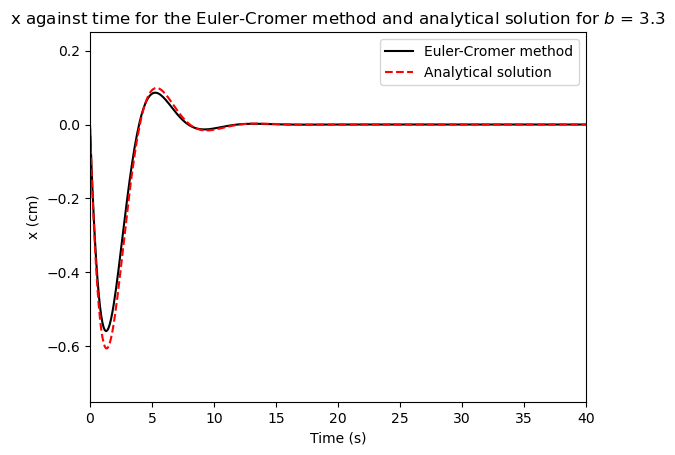

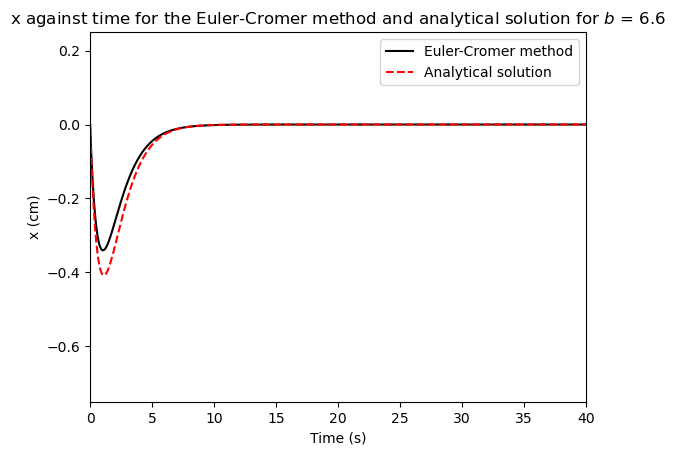

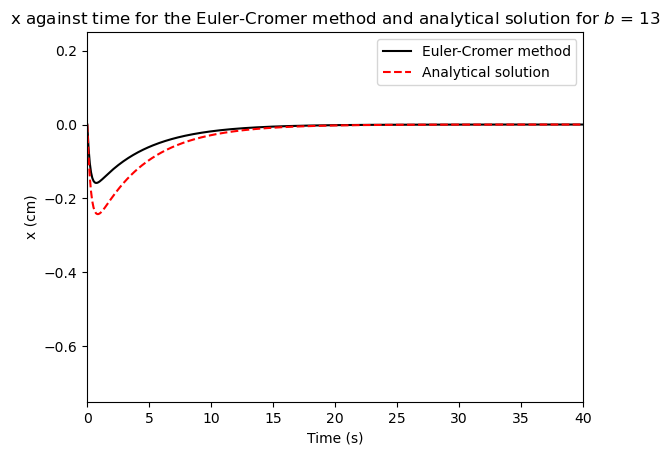

In [18]:
# Finding the solution for a range of damping values
for b in b_values:
    # Plot a figure for the Euler-Cromer method and analytical solution
    # First plot the Euler-Cromer method
    fig_1, ax_1 = plt.subplots(1)
    ax_1.plot(np.arange(0,T,hstep), euler_cromer_method(0, -1, nsteps, hstep)[0], 'k', label='Euler-Cromer method')
    # Plot the analytical solution
    ax_1.plot(np.arange(0,T,hstep), analytic_solution(0, -1, np.arange(0,T,hstep))[0].real, '--r', label='Analytical solution')
    ax_1.set_xlabel('Time (s)')
    ax_1.set_ylabel('x (cm)')
    ax_1.set_title('x against time for the Euler-Cromer method and analytical solution for ' '$b$ = {0:.2g}'.format(b))
    leg = ax_1.legend()
    plt.xlim(0, 40)
    plt.ylim(-0.75, 0.25)
plt.show()

For all cases the Euler-Cromer method perfoms well, although it underestimates the peak magnitude of oscillation slightly.

# Sudden Application Of A Force

The damped oscillator system is generally subject to an external force $F(t)$:
$$F(t) = ma(t) + bv(t) + kx(t),$$
where $F(t)$ is some sudden force applied in a small time frame $\delta t$.

For the Euler-Cromer method the equations must be changed to include a force term. When the force is implemented the new Euler-Cromer equations are given by:
$$a=-\frac{k}{m}x_i-\frac{b}{m}v_i,$$
$$v_{i+1} = v_i+\frac{h}{m}(F_i-\frac{b}{m}v_i-\frac{k}{m}x_i),$$
$$x_{i+1}=x_i+hv_{i+1},$$
where $F_i$ is some forcing term at the time step $i$.

In [19]:
# Define the constants for this section 
# Choose some physics parameters 
b = b_cr / 10 # kg/s
#Choose the step size (in s)
hstep = 0.01
# Determine how many steps there are; we need to use int to ensure we have a whole number of them, otherwise the loops
#won't work
nsteps = int(T / hstep)

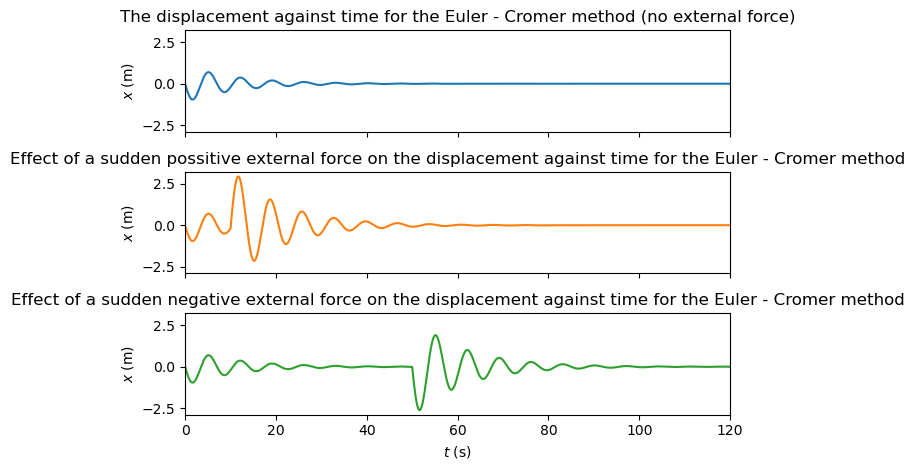

In [20]:
# Implement a sudden force at different points in the oscillation
x_1, _, t_1 = euler_cromer_sudden_force(x0, v0, nsteps, hstep, lambda t: 1000, 1000)
x_2, _, t_2 = euler_cromer_sudden_force(x0, v0, nsteps, hstep, lambda t: -1000, 5000)
# Also find values for no external force
x, _, _ = euler_cromer_method(x0, v0, nsteps, hstep)
# Plot results
fig, axs = plt.subplots(3, sharey = True, sharex = True)
axs[0].plot(np.arange(0,T,hstep), x)
axs[0].set_title('The displacement against time for the Euler - Cromer method (no external force)')
axs[1].plot(t_1, x_1, 'tab:orange')
axs[1].set_title('Effect of a sudden possitive external force on the displacement against time for the Euler - Cromer method')
axs[2].plot(t_2, x_2, 'tab:green')
axs[2].set_title('Effect of a sudden negative external force on the displacement against time for the Euler - Cromer method')
for ax in axs.flat:
    ax.set(xlabel='$t$ (s)', ylabel='$x$ (m)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()   
plt.tight_layout()
plt.xlim(0, 120)
plt.show()

By applying a possitive external sudden force the value of $x$ increases suddenly and then decays due to the damping. For a negative sudden force the value of $x$ decreases suddenly and then decyas as well.

# Applying A Sinusoidal Force

Now we use $F(t) = Asin(wt)$ as the external driving force.

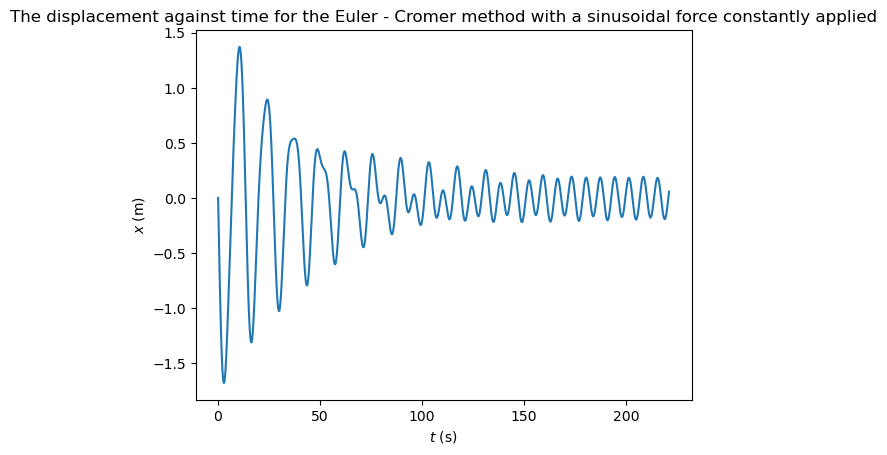

In [21]:
# Define constant
F0 = 0.4
# Find the new x and t
x, _, t = euler_cromer_sinusoidal_force(lambda t: F0 * np.sin(np.sqrt(w0**2 - (((b / m)**2) / 4)) * t), 0, -1, hstep, b)
#Plot results 
plt.plot(t,x)
plt.title('The displacement against time for the Euler - Cromer method with a sinusoidal force constantly applied')
plt.xlabel("$t$ (s)")
plt.ylabel("$x$ (m)")
plt.show()

There are important differences between the response of the system for a sinusoidal external force and for no external force. The main difference is for no external force the system everntually decays so that the displacement becomes 0. However, with a sinusoidal force the system at large time continues to respond with steady oscillations. The effect of the sinusoidal force is most clear at large times.

# Finding The Amplitude Of Oscillations Using The Euler-Cromer Method 

Now we will find the amplitude of the oscillations for a system with $F(t) = Asin(wt)$. Then we will plot $A$ against $w$ for different values of $b$.

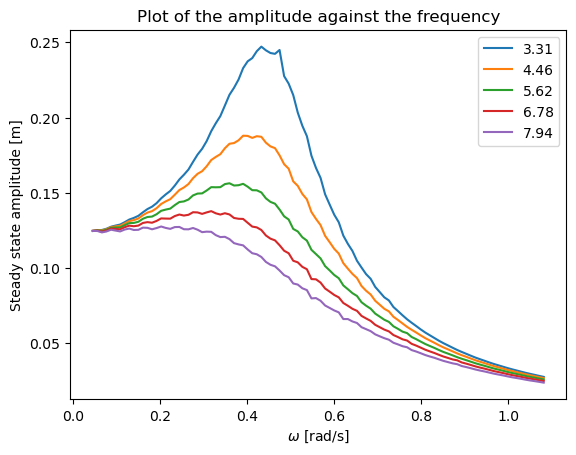

In [22]:
# Define some physical parameters
F0 = 0.1  # N
dampings = np.linspace(b_cr / 2, b_cr * 1.2, num=5)
frequencies = np.linspace(w0 / 20, w0 * 1.2, num=100)
# Create an empty array for the results
results = []
# Loop through each damping value and frequency value
for c in dampings: 
    amplitudes = [] 
    for omega in frequencies:
        # Find the displacement and time using the euler cromer method 
        x_driving, _, t_driving = euler_cromer_sinusoidal_force(lambda t: F0 * np.sin(omega * t), x0, v0, hstep, c)
        # Now find the amplitude by solving a generic sin function with our found displacement and time.
        popt, pcov = curve_fit(sin_func, t_driving[22000:], x_driving[22000:], p0=(F0, omega))
        amplitudes.append(np.abs(popt[0]))
    amplitudes = np.array(amplitudes)
    results.append(amplitudes)
# Plot the results
fig, ax = plt.subplots(1, 1, sharex=True)
ax.set_xlabel('$\omega$ [rad/s]')
ax.set_ylabel('Steady state amplitude [m]') 
ax.set_title('Plot of the amplitude against the frequency')
for amps in results:
    ax.plot(frequencies, amps, label = 'b')
# Round the damping values for the plot
    dampings = np.round(dampings, 2)
    ax.legend(dampings)

As the frequency approaches the natural frequency the system oscillates with larger amplitudes and then decreases as the frequency is increased. We also notice that the peaks do not appear at exactly the same frequency for different damping values. As the damping values are decreased the amplitude increases. 

# Runge - Kutta 4th Order Method

The Runge Kutta method is another common numerical method used in physics. It is given by, 
$$k_1=hf(x_i,y_i),$$
$$k_2=hf(x_i+\frac{1}{2}h,y_i+\frac{1}{2}K_1,$$
$$k_3=hf(x_i+\frac{1}{2}h,y_i+\frac{1}{2}K_2,$$
$$K_4=hf(x_i+h, y_i+K_3),$$
$$y_{n+1}=y_n+\frac{1}{6}k_1+\frac{1}{3}k_2+\frac{1}{3}k_3+\frac{1}{6}k_4$$


Now we find the displacement of the system with no external force and the energy, with a damping term.

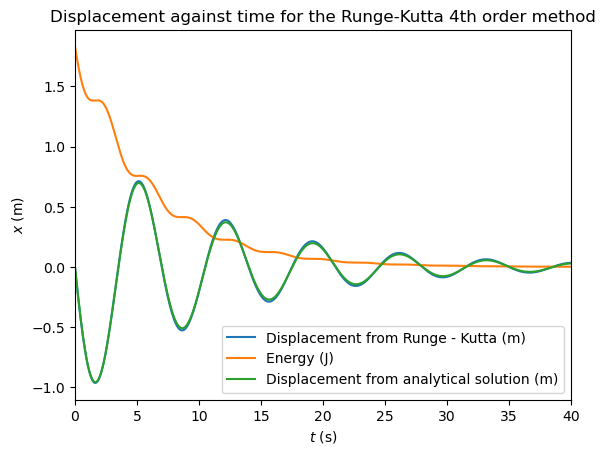

In [23]:
# Define some physical parameters
F0 = 0
time = np.arange(0.0, 200, hstep)
x_analytic, v_analytic, _ = analytic_solution(x0, v0, time)
# Use Runge-Kutta
x, E, _ = runge_kutta_4(x0, v0, time)
# Plot results
plt.plot(time, x)
plt.xlabel('$t$ (s)')
plt.ylabel('$x$ (m)')
plt.title('Displacement against time for the Runge-Kutta 4th order method')
plt.plot(time, E)
plt.plot(time, x_analytic.real)
plt.legend(['Displacement from Runge - Kutta (m)', 'Energy (J)', 'Displacement from analytical solution (m)'],\
           loc='lower right')
plt.xlim(0, 40)
plt.show()

The Runge-Kutta 4th order method seems to perform very well as there is almost no noticeable difference between the analytical and numerical solution.

Now we can see how the error changes with different steps using the Runge-Kutta method.

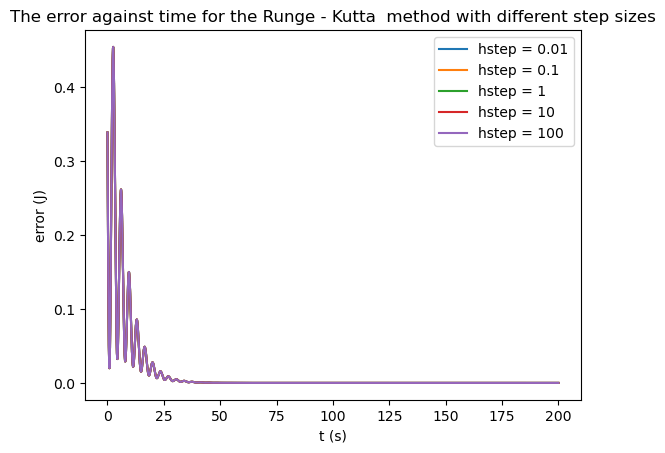

In [24]:
# Choose a range of step sizes (in s)
h = (0.01, 0.1, 1, 10, 100)
# Finding the solution for a range of step sizes 
for h_value in h:
    # Find the error
    _, _, error = runge_kutta_4(x0, v0, time)
    # plot the outcome by displaying the error only 
    plt.plot(time, error, label='hstep = {}'.format(h_value))
# labeling plot 
plt.title('The error against time for the Runge - Kutta  method with different step sizes')
plt.xlabel("t (s)")
plt.ylabel("error (J)")
plt.legend()
plt.show()

It is interesting to see the effect of step size when using the Runge-Kutta method. Unlike the previous methods described, a smaller step size doesnt necessarily mean a smaller error. all the methods oscillate with some error before roughly 38 seconds. However, after this time the error decreases to zero and stays there for the rest of time. The benefits of using the Runge - Kutta 4th order formula are clear. By using relatively large step sizes a very good accuracy can be achived quickly unlike previous methods. This makes the method much more effecient. 

# Phase Space Plots

Phase space plots are useful in physics as they provide a different way to understand a mechnaical system. To understand this we have to look at the Hamiltonian, $H(x, v, t)$. The analysis previoulsy has been for $x$ against $t$, however this only gives information about the path taken by the system but gives no information about the motion. Similarly, analysis of $v$ against $t$ only provides information about the momentum evolution and thus energy of the system, but provides no information on the position of the system. Therefore, we can plot $v$ with respect to $x$ to get information about the position and energy evolution without explicit knowledge of the time.  

We can also check the stability of the system by varying the intial conditions, $x_0$ and $v_0$. If the characteristic shape of the phase plots change drastically the system must be unstable. 

Finally, we then plot phase plots for diferent driving forces and see how varying the driving frequency changes the plots.

In [25]:
# Choose some physics parameters 
b = b_cr / 10 # kg/s
F0_1 = 2 # N
F0_2 = 4 # N

# Phase Plots For Varying Initial Conditions

First we vary $x_0$ and see how this changes the phase plots.

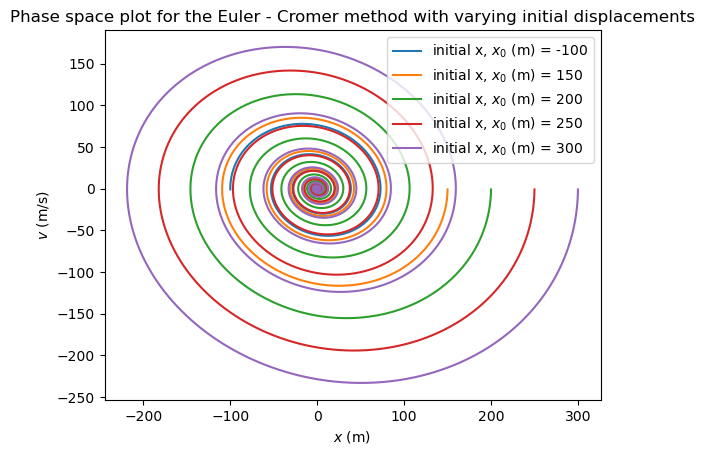

In [26]:
# Choose a range of initial conditions in x (in m)
x_initial = (-100 ,150, 200, 250, 300)
# Finding the solution for a range of initial conditions in x
for x_value in x_initial:
    x_euler_cromer, v_euler_cromer, _ = x, _, t = euler_cromer_method(x_value, v0, nsteps, hstep)
    plt.plot(x_euler_cromer, v_euler_cromer, label='initial x, $x_0$ (m) = {}'.format(x_value))
# plot the solution 
plt.title('Phase space plot for the Euler - Cromer method with varying initial displacements')
plt.xlabel("$x$ (m)")
plt.ylabel("$v$ (m/s)")
plt.legend()
plt.show()

We can see that for all the $x_0$ values the plots have a characteristic circular shape. This shows the system decaying over time until they reach a displacement of zero and the system stops oscillating. For a completely stable system we would expect the characteristic shape of the different curves to be similiar. In this plot we see they are similiar and the curves get closer together as the system progresses. 

Next we vary $v_0$ and see how this changes the phase plot.

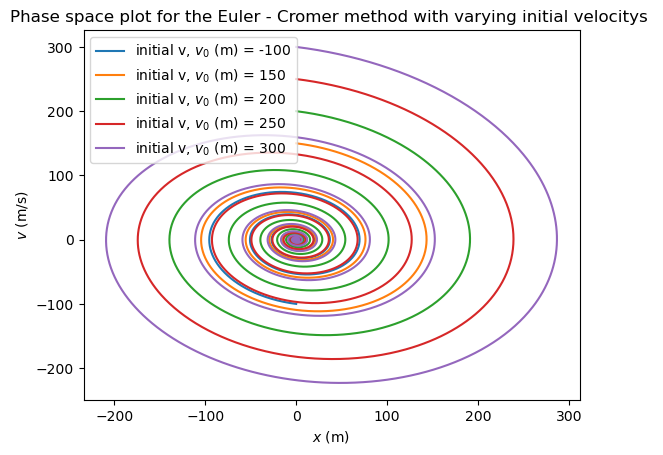

In [27]:
# Choose a range of initial conditions in v  (in m/s)
v_initial = (-100 ,150, 200, 250, 300)
# Finding the solution for a range of initial conditions in v
for v_value in v_initial:
    x_euler_cromer, v_euler_cromer, _ = euler_cromer_method(x0, v_value, nsteps, hstep)
    plt.plot(x_euler_cromer, v_euler_cromer, label='initial v, $v_0$ (m) = {}'.format(v_value))
# plot the solution
plt.title('Phase space plot for the Euler - Cromer method with varying initial velocitys ')
plt.xlabel("$x$ (m)")
plt.ylabel("$v$ (m/s)")
plt.legend()
plt.show()

The pattern seen for varying $v_0$ is the same as that seen for varying $x_0$.

# Phase Plots For Different Driving Forces 

First we apply a driving force where $F = Asin(wt)$ and then create the phase plot.

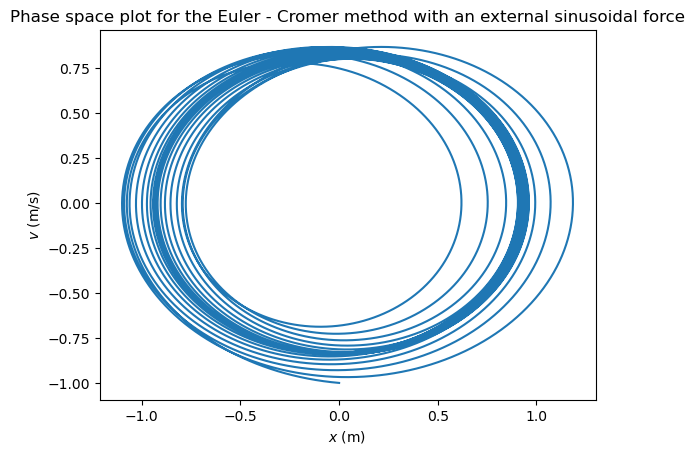

In [28]:
x_euler_cromer, v_euler_cromer, _ = euler_cromer_sinusoidal_force(lambda t: F0_1 * np.sin(np.sqrt(w0**2 - (((b / m)\
                                         **2) / 4)) * t), 0, -1, hstep, b)
# plot the results 
plt.plot(x_euler_cromer, v_euler_cromer)
# labeling plot 
plt.title('Phase space plot for the Euler - Cromer method with an external sinusoidal force')
plt.xlabel("$x$ (m)")
plt.ylabel("$v$ (m/s)")
plt.show()

The characteristic shape is similiar to that of the system with no external driving force. However, the lines in this plot cross at some points. If we choose a point on a phase plot where the lines dont intersect, we would be able to find the next point in time by looking at the phase plot. In this case there is an ambiguity in what the next point in the system is because of the lines crossing.

Now we apply a driving force where $F = Asin(wt) + Bcos(wt)$ and then create the phase plot.

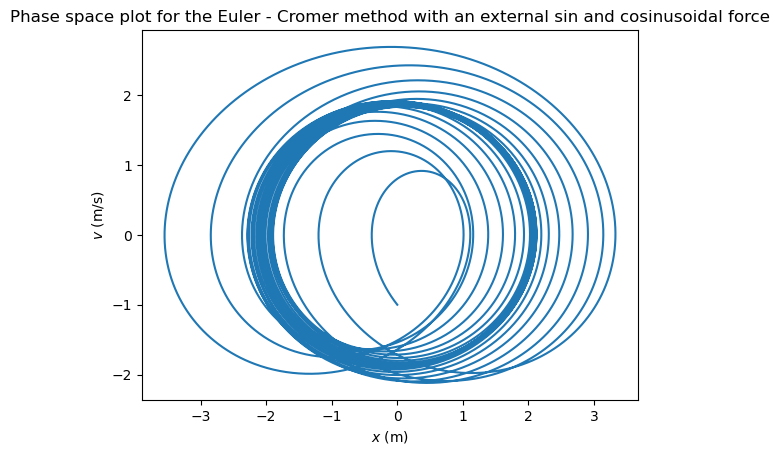

In [29]:
x_euler_cromer, v_euler_cromer, _ = euler_cromer_sinusoidal_force(lambda t: F0_1 * np.sin(np.sqrt(w0**2 - (((b / m)\
                                                    **2) / 4)) * t) + F0_2 * np.cos(np.sqrt(w0**2 - (((b / m)**2) / 4)) * t),\
                                                                  0, -1, hstep, b)
# plot the results
plt.plot(x_euler_cromer, v_euler_cromer)
plt.title('Phase space plot for the Euler - Cromer method with an external sin and cosinusoidal force')
plt.xlabel("$x$ (m)")
plt.ylabel("$v$ (m/s)")
plt.show()

Now we apply a driving force where $F = \frac{1}{t}(Asin(wt) + Bcos(wt))$ and then create the phase plot.

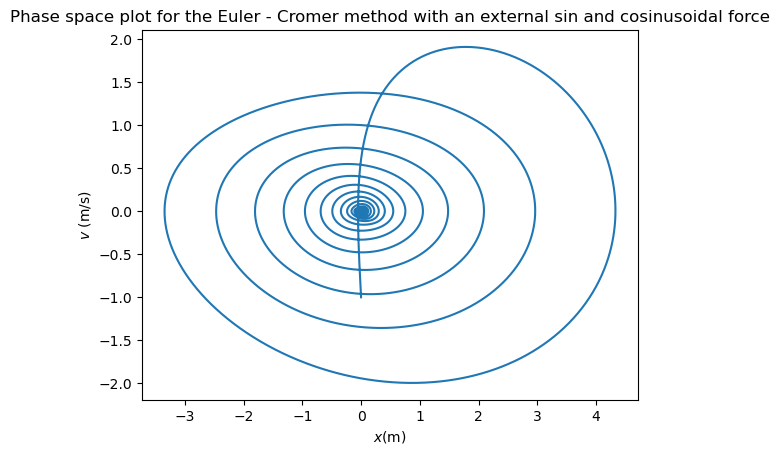

In [30]:
x_euler_cromer, v_euler_cromer, _ = euler_cromer_sinusoidal_force(lambda t: (1 / t) * (F0_1 * np.sin(np.sqrt(w0**2 - (((b / m)\
                                                    **2) / 4)) * t) + F0_2 * np.cos(np.sqrt(w0**2 - (((b / m)**2) / 4)) * t)),\
                                                                  0, -1, hstep, b)
# plot the results  
plt.plot(x_euler_cromer, v_euler_cromer)
plt.title('Phase space plot for the Euler - Cromer method with an external sin and cosinusoidal force')
plt.xlabel("$x$(m)")
plt.ylabel("$v$ (m/s)")
plt.show()

Now we apply a driving force where $F = \frac{1}{mt}(Asin(wt) + Bcos(wt))$ and then create the phase plot.

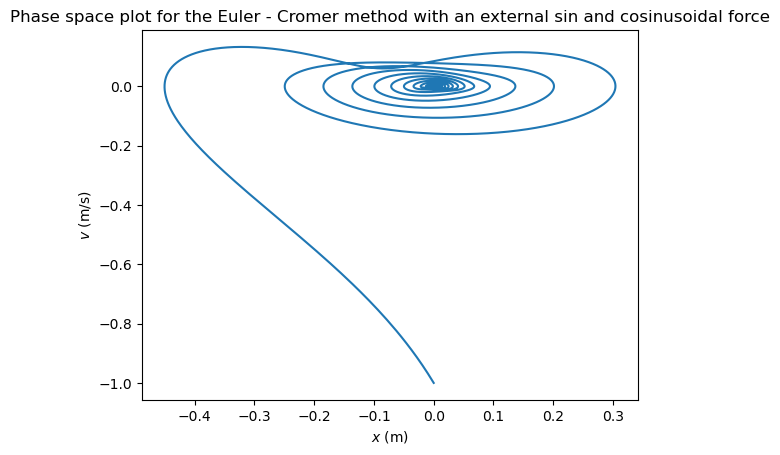

In [31]:
x_euler_cromer, v_euler_cromer, _ = euler_cromer_sinusoidal_force(lambda t: (1 / (m*t)) * (F0_1 * np.sin(np.sqrt(w0**2 - \
                                            (((b / m)**2) / 4)) * t) + F0_2 * np.cos(np.sqrt(w0**2 - (((b / m)**2) / 4)) * t)),\
                                                                  0, -1, hstep, b)
# plot the results  
plt.plot(x_euler_cromer, v_euler_cromer)
plt.title('Phase space plot for the Euler - Cromer method with an external sin and cosinusoidal force')
plt.xlabel("$x$ (m)")
plt.ylabel("$v$ (m/s)")
plt.show()

All the phase plots previoulsy show a varying velocity however, an interesting feature of this plot is the almost constant velocity for the majority of the systems displacement.

Next we can look at out how the phase plots look with $F = Asin(wt)$ and a varying frequency, $w$.

In [32]:
%matplotlib widget 
# set up plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(True)
@widgets.interact(omega=(w0 / 100, w0 * 10, 0.1))
# This function needs to be contained whithin the cell where the graph is plotted. This enables the graph to be constantly
#updated.
def update(omega = 0.01):
    #Remove old lines from plot and plot new one
    [l.remove() for l in ax.lines]
    # plot the results  
    ax.plot(euler_cromer_sinusoidal_force(lambda t: F0_1 * np.sin(omega * t), 0, -1, hstep, b)[0],\
            euler_cromer_sinusoidal_force(lambda t: F0_1 * np.sin(omega * t), 0, -1, hstep, b)[1], color='C0')
    plt.title('Phase space plot for the Euler - Cromer method with an external sinusoidal force')
    plt.xlabel("Displacement (m)")
    plt.ylabel("velocity (m/s)")
    return plt.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.01, description='omega', max=9.011043784254069, min=0.00901104378425…

The slider above varies $w$. You may have to wait a short time for the graph to be updated. The zoom in features can also be used to see certain plots better. Many more interesting characteristic shapes are formed by varying $w$. This change shows the instability of the system with varying $w$. The plot demonstrates the movement away from steady state at different values of $w$.